# Decision Trees

This notebook serves the purpose of the completion of the exercises in Chapter 6 on Decision Trees.    

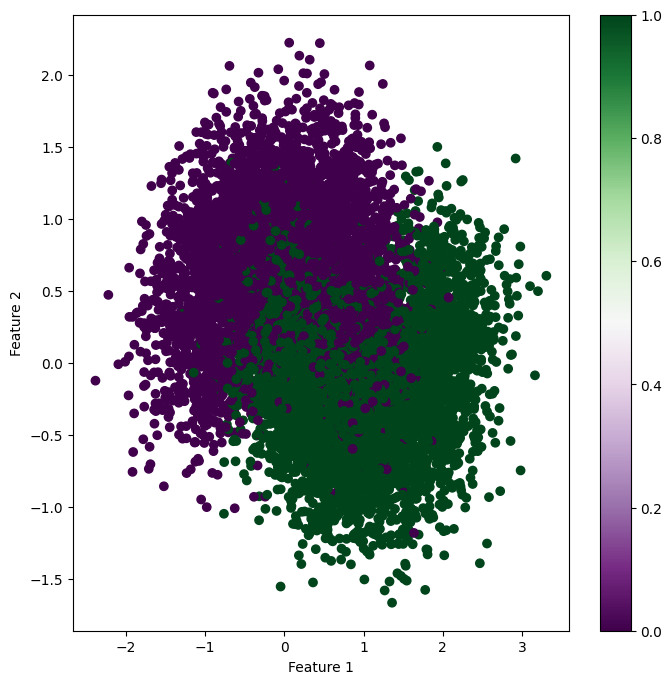

In [242]:
from sklearn.datasets import make_moons
from matplotlib import colormaps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # type: ignore
import pandas as pd
import numpy as np


# Making our datset
# Ensure reproducability
X,y = make_moons(n_samples=10000,noise=0.4,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


# Visualizing our moons
fig, ax = plt.subplots(1,1, figsize=(8,8)) # type: ignore
cmap = colormaps['PRGn']
# Colorbar requires the artist that uses the colorbar
scatter = ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap)  # type: ignore
ax.set_xlabel('Feature 1')  # type: ignore
ax.set_ylabel('Feature 2')  # type: ignore
fig.colorbar(mappable=scatter)  # type: ignore




In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(random_state=42)
grid_parameters = [{'max_leaf_nodes':[5,10,15,20,50],'min_samples_split': [10,20,50],'min_samples_leaf':[5,10,15,20,25]}]
grid_search = GridSearchCV(clf, param_grid=grid_parameters,cv=3)
grid_search.fit(X_train,y_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df.sort_values(by='mean_test_score',ascending=False)['mean_test_score'])
best_params = grid_search.best_params_
print(best_params)






46    0.855375
47    0.855375
45    0.855375
74    0.855250
73    0.855250
        ...   
66    0.849500
67    0.849500
61    0.849376
63    0.848875
64    0.848875
Name: mean_test_score, Length: 75, dtype: float64
{'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}


In [244]:
from sklearn.metrics import accuracy_score

# Unpack best params
clf_finetuned = DecisionTreeClassifier(random_state=42, **best_params)
clf_finetuned.fit(X_train,y_train)
y_pred = clf_finetuned.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f'The accuracy of the base fine-tuned model is: {accuracy}')


The accuracy of the base fine-tuned model is: 0.87


In [245]:
X_train.shape

(8000, 2)

In [246]:
from scipy.stats import mode

# Shuffle split and train different models on the data using the best params that we found
# This is a simplified variation of an ensemble learning approach, here we train only on different datasets (bagging)
# Unlike random forests where we train using different hyperparameters (as well as bagging)

predictions = []
rng = np.random.default_rng(seed=42)
for i in range(1000):
    # Provides replacement and shuffling by default, no need to use shufflesplit
    # Replace = True, so that we see the entire dataset
    index = rng.choice(X_train.shape[0],size=100,replace=False, shuffle=True)
    clf = DecisionTreeClassifier(random_state=42, **best_params)
    clf.fit(X_train[index],y_train[index])
    y_test_pred = clf.predict(X_test) 
    predictions.append(y_test_pred)

# axis 0 
mode_result = mode(np.array(predictions),axis=0)
y_test_pred = mode_result.mode


Let us evaluate the models performance. As we did not select a different scoring funciton, our gridsearch used the default scoring method of the decision tree classifier which is accuracy. Another common scoring method (for regressors) is the coeffecient of determination. As to select the correct metric, enabling comparisons between models, it is best practice to confirm this for custom pipelines befor using a metric for model evaluation. How to do this will be shown in the following cell, after which we will compare our ensemble models performance to the model that we trained. 

In [247]:
# If a different metric was set for grid_search using the hyperparameter 'scoring'
print(grid_search.scoring)
# Else, will show you the docstring of your classifiers scoring method, which states 
# metric that was use
help(clf.score)


None
Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.tree._classes.DecisionTreeClassifier instance
    Return :ref:`accuracy <accuracy_score>` on provided data and labels.

    In multi-label classification, this is the subset accuracy
    which is a harsh metric since you require for each sample that
    each label set be correctly predicted.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples.

    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        True labels for `X`.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    Returns
    -------
    score : float
        Mean accuracy of ``self.predict(X)`` w.r.t. `y`.



In [248]:
from sklearn.metrics import accuracy_score

acccuracy = accuracy_score(y_test,y_test_pred)
print(acccuracy)

0.8735


# Conclusion

By training an ensemble method, we were able to increase our accuracy from  
0.8565 to 0.8705 on the test set using a majority-vote approach.  

Interestingly, ensemble methods can also be computationally efficient. Suppose it takes 1 hour to train a model with *m* features and 1,000 samples. Since CART (as used in scikit-learn) has a training time complexity of O(m·n·log(n)), training on 10,000 instances would take roughly 13× longer than the 1,000-sample baseline, not just 10×. In contrast, training 10 smaller models (each with 1,000 samples) would take only 10× as long.  

Naturally, this computational trade-off is not the only consideration: larger single models typically generalize better. Still, this illustrates why ensembles are attractive, they can combine higher accuracy with a better cost–benefit balance than a single large model.
